In [1]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
import nltk
import matplotlib.pyplot as plt

In [2]:
# Load the data
reviews = pd.read_csv('/content/Customer Reviews-4 - Sheet1.csv')
manual_tags = pd.read_csv('/content/Department_-_Customer Review-4_2 - Sheet1.csv')

In [3]:
reviews

,Customer Reviews
0,the best road king you can get in the market r...
1,i must say tata harrier has absolutely best ro...
2,"tata harrier is the best car from tata, best r..."
3,real off-road car with premium looks.
4,i bought this car last year still i love to dr...
...,...
394,look at the additional equipment that seltos w...
395,"kia seltos officially unveiled, \n- to go on s..."
396,autocar says there are some features like fron...
397,blind spot monitor\n3.


In [4]:
manual_tags

,Unnamed: 0,Unnamed: 1,Department,Unnamed: 3,Customer Review
0,NaN,NaN,road presence,NaN,the best road king you can get in the market r...
1,NaN,NaN,road presence,NaN,i must say tata harrier has absolutely best ro...
2,NaN,NaN,road presence,NaN,"tata harrier is the best car from tata, best r..."
3,NaN,NaN,road presence,NaN,real off-road car with premium looks.
4,NaN,NaN,road presence,NaN,i bought this car last year still i love to dr...
...,...,...,...,...,...
394,NaN,NaN,safety features,NaN,look at the additional equipment that seltos w...
395,NaN,NaN,safety features,NaN,"kia seltos officially unveiled, \n- to go on s..."
396,NaN,NaN,safety features,NaN,autocar says there are some features like fron...
397,NaN,NaN,safety features,NaN,blind spot monitor\n3.


In [5]:
reviews.columns

Index(['Customer Reviews'], dtype='object')

In [6]:
# Download NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [7]:
# Preprocess text
def preprocess_text(text):
    text = re.sub(r'\W', ' ', text)
    text = text.lower()
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'\d+', '', text)
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words])
    return text

reviews['cleaned_review'] = reviews['Customer Reviews'].apply(preprocess_text)

In [8]:
# Drop unnecessary columns and preprocess manual tags
manual_tags = manual_tags.drop(['Unnamed: 0', 'Unnamed: 1', 'Unnamed: 3'], axis=1)
manual_tags['cleaned_review'] = manual_tags['Customer Review'].apply(preprocess_text)

In [9]:
# Vectorization
vectorizer = TfidfVectorizer(max_features=1000)
X = vectorizer.fit_transform(reviews['cleaned_review'])


In [10]:
# Determine optimal number of clusters using the elbow method
wcss = []
for i in range(1, 21):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=42)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)


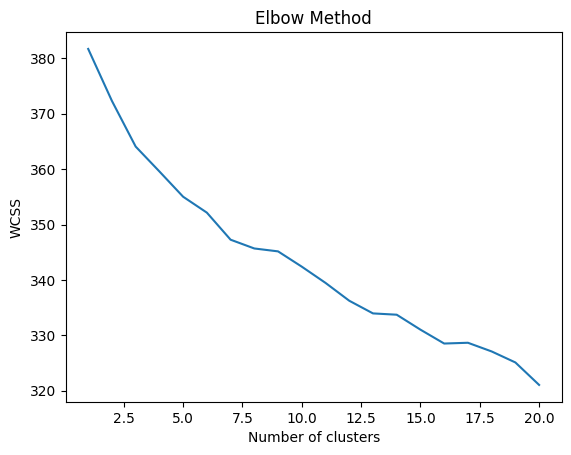

In [11]:
plt.plot(range(1, 21), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()


In [17]:
# Perform K-Means clustering with the optimal number of clusters
optimal_k = 6  # Adjust based on elbow plot
kmeans = KMeans(n_clusters=optimal_k, init='k-means++', max_iter=300, n_init=10, random_state=42)
y_kmeans = kmeans.fit_predict(X)
reviews['cluster'] = y_kmeans


In [18]:
# Display cluster reviews
for i in range(optimal_k):
    print(f"Cluster {i}")
    cluster_reviews = reviews[reviews['cluster'] == i]
    print(cluster_reviews['cleaned_review'].head())

Cluster 0
25     tata harrier definitely package feature equipm...
40     tata harrier definitely package feature equipm...
75     word badass indicates towards kia seltos great...
107    harrier built quality far better hector others...
120    amazing look concept atata bestcar ever driven...
Name: cleaned_review, dtype: object
Cluster 1
249    also opinion weight door part overall build qu...
250    also opinion weight door part overall build qu...
251    originally posted abhishek also opinion weight...
348            ii degree camera iii blind spot monitor b
371                             orvms massive blind spot
Name: cleaned_review, dtype: object
Cluster 2
0                      best road king get market right
1    must say tata harrier absolutely best road pre...
2    tata harrier best car tata best road presence ...
4    bought car last year still love drive car anyw...
5    jeep compass best roading car jeep compass ser...
Name: cleaned_review, dtype: object
Cluster 3
3      

In [19]:
# Vectorize manual tagged data
X_manual_tags = vectorizer.transform(manual_tags['cleaned_review'])

# Assign clusters to manual tags
manual_tags['predicted_cluster'] = kmeans.predict(X_manual_tags)


In [20]:
# Benchmarking
for i in range(optimal_k):
    print(f"\nCluster {i} mapping to Departments:")
    cluster_reviews = manual_tags[manual_tags['predicted_cluster'] == i]
    print(cluster_reviews['Department'].value_counts())



Cluster 0 mapping to Departments:
Department
build quality      109
safety features     15
road presence        3
Name: count, dtype: int64

Cluster 1 mapping to Departments:
Department
safety features    28
build quality       3
Name: count, dtype: int64

Cluster 2 mapping to Departments:
Department
build quality      64
road presence      13
safety features     1
Name: count, dtype: int64

Cluster 3 mapping to Departments:
Department
road presence    73
build quality     2
Name: count, dtype: int64

Cluster 4 mapping to Departments:
Department
safety features    48
Name: count, dtype: int64

Cluster 5 mapping to Departments:
Department
build quality      38
road presence       1
safety features     1
Name: count, dtype: int64
